In [1]:
import os
import sys
import glob

try:
    sys.path.append(glob.glob('../carla/PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass


import carla

import math
import time
import hydra
import logging
import argparse


from numpy import random
from omegaconf import DictConfig, OmegaConf, ValidationError

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.pgm import PGM
from utils.weather import Weather
from core.vehicle_manager import VehicleManager
from core.pedestrian_manager import PedestrianManager
from utils.common import get_actor_blueprints

from hydra.core.config_store import ConfigStore
from schemas.pgm_schema import PGMModel
from schemas.weather_schema import WeatherSchema, SunSchema
from schemas.config_schema import ConfigSchema

c:\Users\aadim\.conda\envs\carla-pgm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def main(cfg: DictConfig):
    logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
    
    client = carla.Client(cfg.host, cfg.port)
    client.set_timeout(10.0)

    pgm = PGM(cfg)
    pgm_variables = pgm.get_variables()
    pgm_states = pgm.get_states()

    # get rain state based on weather
    rain_value = cfg.weather.rain
    rain_state = None
    for s in pgm_states.Rain:
        if (rain_value <= s.value):
            rain_state = s.name
            break

    print(rain_state)

    traffic_state = pgm.predict_state(
        [pgm_variables.Traffic, pgm_variables.Speed, pgm_variables.Pedestrians], 
        evidence={
            pgm_variables.Rain: rain_state
        }
    )

    rng = random.default_rng()
    num_of_vehicles = pgm_states.Traffic[traffic_state[pgm_variables.Traffic]].value
    num_of_vehicles = rng.poisson(num_of_vehicles)
    print(f"Spawning {num_of_vehicles} vehicles.")

    speed = pgm_states.Speed[traffic_state[pgm_variables.Speed]].value
    print(f"Maximum speed is {speed}% of the speed limit.")

    num_of_pedestrians = pgm_states.Pedestrians[traffic_state[pgm_variables.Pedestrians]].value
    num_of_pedestrians = rng.poisson(num_of_pedestrians)
    print(f"Spawning {num_of_pedestrians} pedestrians.")

    vcfg = hydra.compose(config_name="vehicle_manager.yaml")
    # print(OmegaConf.to_yaml(vcfg, resolve=True))
    tm = VehicleManager(client=client, cfg=vcfg, asynch=cfg.asynch)

    # v = world.player.get_velocity()
    # 'Speed:   % 15.0f km/h' % (3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2)),
    speed_history = list()

    pcfg = hydra.compose(config_name="pedestrian_manager.yaml")
    # print(pcfg)
    pm = PedestrianManager(client=client, cfg=pcfg, asynch=cfg.asynch)
    try:
        world = client.get_world()

        all_vehicles = tm.spawn_vehicles(number_of_vehicles=num_of_vehicles)
        pm.spawn_walkers(number_of_walkers=num_of_pedestrians, percentagePedestriansRunning=pcfg.running_percentage, percentagePedestriansCrossing=pcfg.crossing_percentage)

        # Dynamic Weather
        speed_factor = 1.0
        update_freq = 0.5 / speed_factor

        weather = Weather(world.get_weather())
        weather.setWeather(cfg.weather)
        world.set_weather(weather.weather)

        elapsed_time = 0.0

        tm.update_global_speed(speed)

        synchronous_master = world.get_settings().synchronous_mode
        while True:
            if not cfg.asynch and synchronous_master:
                world.tick()
            else:
                timestamp = world.wait_for_tick(seconds=30.0).timestamp
                elapsed_time += timestamp.delta_seconds
                # if elapsed_time > update_freq:
                #     weather.tick(speed_factor * elapsed_time)

                #     world.set_weather(weather.weather)
                #     sys.stdout.write('\r' + str(weather) + 12 * ' ')
                #     sys.stdout.flush()
                #     elapsed_time = 0.0
            v = world.get_actor(all_vehicles[0]).get_velocity()
            current_speed = 3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2)
            speed_history.append(current_speed)
            # print('Speed:   % 15.0f km/h' % (current_speed))
    finally:

        tm.destroy()
        pm.destroy()
        time.sleep(0.5)
        return speed_history

In [5]:
try:
    cs = ConfigStore.instance()
    cs.store(group="weather", name="base_weather_model", node=WeatherSchema)
    cs.store(group="weather/sun", name="base_sun_model", node=SunSchema)
    cs.store(group="model", name="base_pgm_model", node=PGMModel)
    cs.store(name="base_config_model", node=ConfigSchema)
    with hydra.initialize(version_base=None, config_path="../conf"):
        cfg = hydra.compose(
            config_name="config", 
            overrides=[
                "weather=clear",
                "weather/sun=night"
                
                ])
        print(cfg.weather)
        clear_speeds = main(cfg)
except KeyboardInterrupt:
    pass
finally:
    print('\ndone.')

{'cloudiness': 10.0, 'rain': 0.0, 'puddles': 0.0, 'wind': 5.0, 'fog': 0.0, 'wetness': 0.0, 'sun': {'azimuth': 0.0, 'altitude': -90.0}}
NO_RAIN


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

Spawning 37 vehicles.
Maximum speed is -30% of the speed limit.
Spawning 17 pedestrians.



done.


RuntimeError: time-out of 10000ms while waiting for the simulator, make sure the simulator is ready and connected to 127.0.0.1:5001

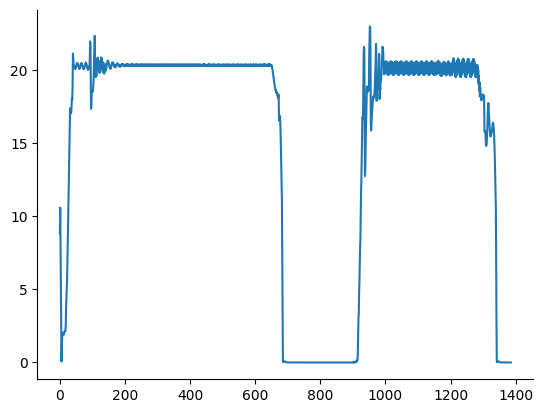

In [46]:
import matplotlib.pyplot as plt

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(clear_speeds)
plt.show()

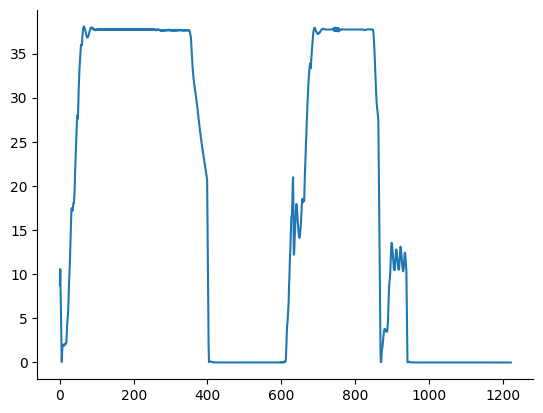

In [37]:
import matplotlib.pyplot as plt

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(clear_speeds)
plt.show()

In [41]:
len(clear_speeds)

1223

TypeError: scatter() missing 1 required positional argument: 'y'

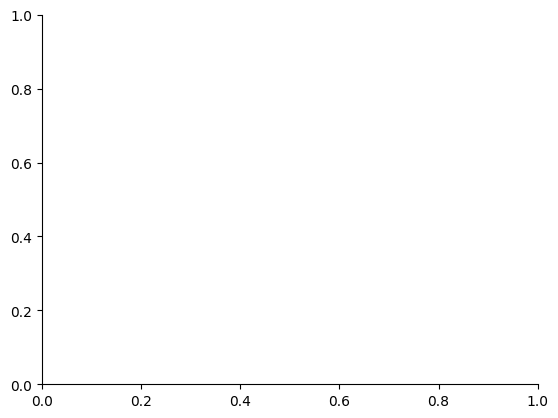

In [43]:
import matplotlib.pyplot as plt

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter([rain_speeds[:len(clear_speeds)], clear_speeds])
plt.show()

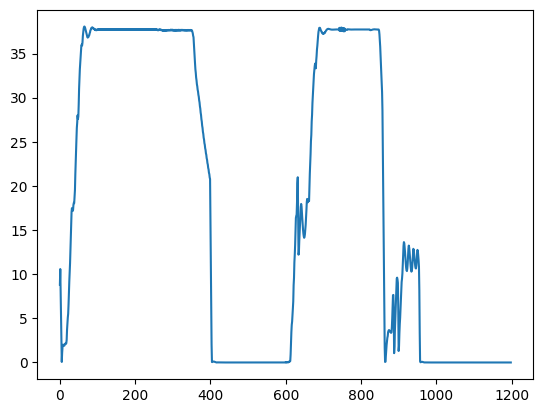

In [19]:
import matplotlib.pyplot as plt

plt.plot(speeds)
plt.show()